In [38]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
 # Old: from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
# Old: from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split



cols = ['price',
        'accommodates',
        'bedrooms',
        'beds',
        'neighbourhood_cleansed',
        'room_type',
        'cancellation_policy',
        'instant_bookable',
        'reviews_per_month',
        'number_of_reviews',
        'availability_30',
        'review_scores_rating'
        ]

# read the file into a dataframe
df = pd.read_csv(LISTINGSFILE, usecols=cols, compression='infer')

len(df.index)

7029

In [39]:
df.head()

,neighbourhood_cleansed,room_type,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month
0,Seacliff,Entire home/apt,2,1.0,1.0,$350.00,30,8,89.0,f,strict,0.28
1,Seacliff,Entire home/apt,6,4.0,2.0,$300.00,0,0,NaN,f,flexible,NaN
2,Seacliff,Private room,2,1.0,1.0,$119.00,15,10,92.0,f,strict,2.33
3,Seacliff,Private room,2,1.0,1.0,$79.00,0,0,NaN,f,flexible,NaN
4,Seacliff,Entire home/apt,8,3.0,4.0,$695.00,0,1,100.0,t,strict,0.36


In [41]:
# the number of entries with 0 'number_of_reviews' which do not a NaN for 'reviews_per_month'
len(df[(df.number_of_reviews == 0) & (pd.isnull(df.number_of_reviews) == False)
       & (pd.isnull(df.reviews_per_month) == False)].index)

0

In [42]:
# the number of entries with at least 1 'number_of_reviews' which have a NaN for 'reviews_per_month'
len(df[(df.number_of_reviews != 0) & (pd.isnull(df.number_of_reviews) == False)
       & (pd.isnull(df.reviews_per_month) == True)].index)

0

In [43]:
# So we need to do some cleaning.

# First fixup "rewievs_per_month" where there are no reviews
df['reviews_per_month'].fillna(0, inplace=True)

# Just drop rows with bad/weird values

df = df[df.bedrooms != 0]
df = df[df.beds != 0]
df = df[df.price != 0]
df = df.dropna(axis=0)

len(df.index)

5246

In [44]:
df = df[df.bedrooms == 1]
len(df.index)

3821

In [45]:
# remove the $ from the price and convert to float
df['price'] = df['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)
df.price.head(5)

0    350.0
2    119.0
5     80.0
7    215.0
9    224.0
Name: price, dtype: float64

In [46]:
df.head(1)

,neighbourhood_cleansed,room_type,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,instant_bookable,cancellation_policy,reviews_per_month
0,Seacliff,Entire home/apt,2,1.0,1.0,350.0,30,8,89.0,f,strict,0.28


In [47]:
# Get feature ancoding for categorical variables
n_dummies = pd.get_dummies(df.neighbourhood_cleansed)
rt_dummies = pd.get_dummies(df.room_type)
xcl_dummies = pd.get_dummies(df.cancellation_policy)

# Convert boolean column to a single boolean value whether this listing has 
# instant booking available
ib_dummies = pd.get_dummies(df.instant_bookable, prefix="instant")
ib_dummies = ib_dummies.drop("instant_f", axis=1)


# replace the old colums with our new one-hot encoded ones
alldata = pd.concat((df.drop(['neighbourhood_cleansed', \
    'room_type', 'cancellation_policy', 'instant_bookable'], axis=1), \
    n_dummies.astype(int), rt_dummies.astype(int), \
    xcl_dummies.astype(int), ib_dummies.astype(int)), \
    axis=1)
allcols = alldata.columns
alldata.head(5)

,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,reviews_per_month,Bayview,Bernal Heights,...,Western Addition,Entire home/apt,Private room,Shared room,flexible,moderate,strict,super_strict_30,super_strict_60,instant_t
0,2,1.0,1.0,350.0,30,8,89.0,0.28,0,0,...,0,1,0,0,0,0,1,0,0,0
2,2,1.0,1.0,119.0,15,10,92.0,2.33,0,0,...,0,0,1,0,0,0,1,0,0,0
5,2,1.0,1.0,80.0,20,24,94.0,1.13,0,0,...,0,0,1,0,0,1,0,0,0,0
7,3,1.0,1.0,215.0,0,1,100.0,0.18,0,0,...,0,1,0,0,0,1,0,0,0,0
9,4,1.0,3.0,224.0,0,57,97.0,3.94,0,0,...,0,1,0,0,0,0,1,0,0,0


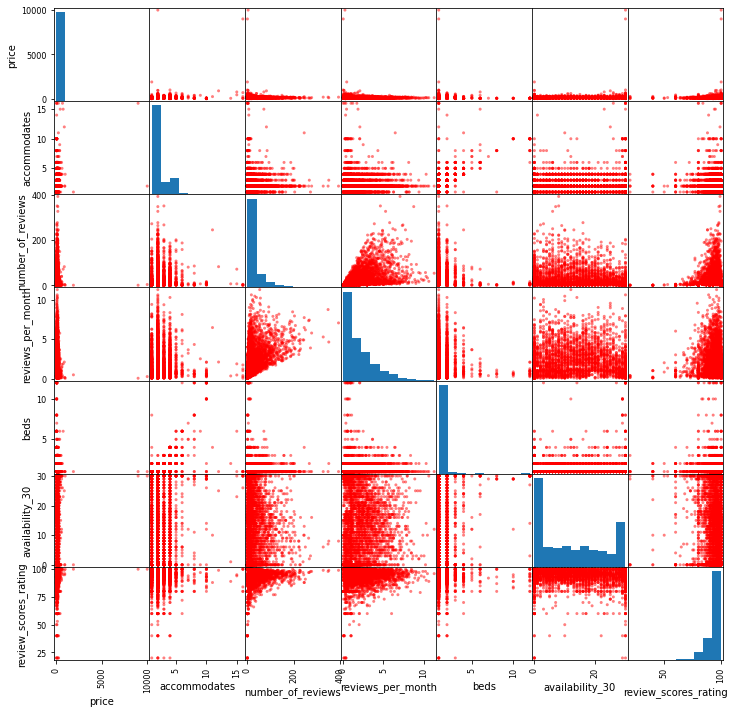

In [48]:
scattercols = ['price','accommodates', 'number_of_reviews', 'reviews_per_month', 'beds', 'availability_30', 'review_scores_rating']
axs = pd.plotting.scatter_matrix(alldata[scattercols],
                        figsize=(12, 12), c='red')

Text(0, 0.5, 'Median Absolute Error')

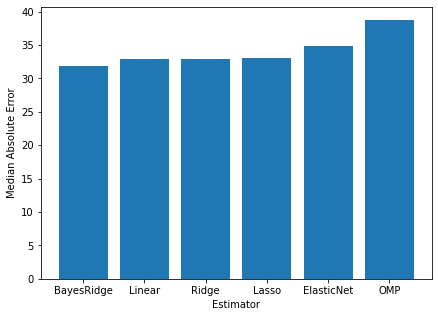

In [49]:
rs = 1
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(alldata.drop(['price'], axis=1),
                                                    alldata.price, test_size=0.2, random_state=20)

for e in ests:
    e.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, e.predict(X_test))
    #print "got error %0.2f" % this_err
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

In [52]:
n_est = 300

tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 2 ],
    "loss" : [ 'ls', 'lad' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
best

GradientBoostingRegressor(learning_rate=0.01, loss='lad', max_depth=4,
                          n_estimators=300)

In [54]:
abs(clf.best_score_)

23.60735081682043

Text(0, 0.5, 'Least Absolute Deviation')

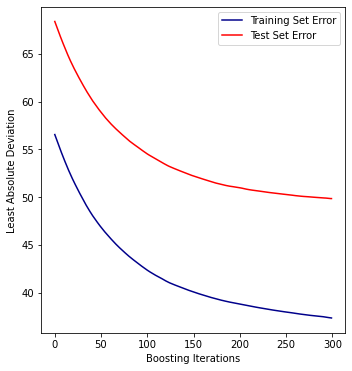

In [55]:
# plot error for each round of boosting
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

Text(0.5, 1.0, 'Variable Importance')

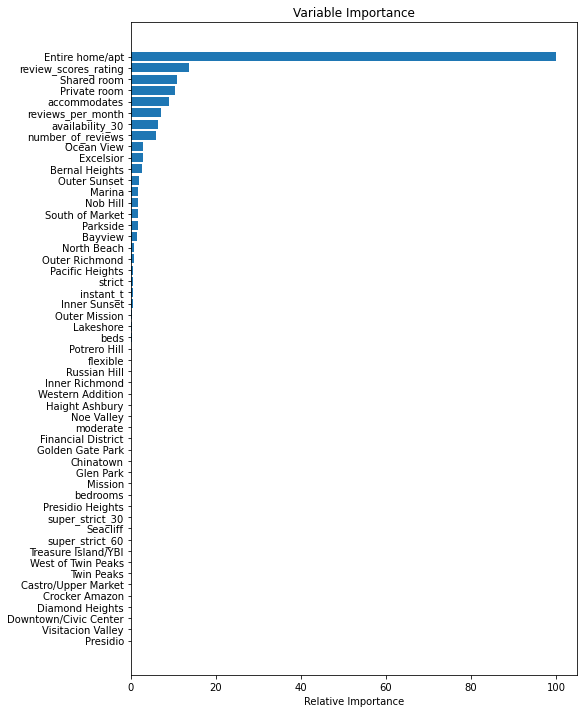

In [56]:
feature_importance = clf.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(8,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')